In [ ]:
# TODO
# check net model of each stage, plot accuracy against iteration

In [1]:
# Python 2
import numpy as np
import pickle
import sys
from __future__ import print_function
from os.path import join
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Setup caffe
caffe_dir = '/home/libo/caffe'
sys.path.insert(0, join(caffe_dir, 'python'))
import caffe
from caffe.io import load_image
caffe.set_mode_cpu()

In [ ]:
# Convert mean file to numpy array
train_mean_bp = caffe.proto.caffe_pb2.BlobProto()
with open(join(caffe_dir, 'pascal12/ilsvrc12_mean.binaryproto'), mode='rb') as h:
    train_mean_bp.ParseFromString(h.read())
train_mean = np.array(caffe.io.blobproto_to_array(train_mean_bp))[0]

In [ ]:
net = caffe.Classifier(model_file=join(caffe_dir, 'pascal12/deploy.prototxt'),
                       pretrained_file=join(caffe_dir, 'pascal12/temp/train_iter_10000.caffemodel'),
                       mean=train_mean.mean(1).mean(1),
                       channel_swap=(2, 1, 0),
                       raw_scale=255,
                       image_dims=(256, 256))

In [2]:
with open('preprocess.pickle', mode='rb') as h:
    df = pickle.load(h)
df_test = df[df['split'] == 'test']
print(df_test.dtypes)
print(df_test.head())

img_name             object
obj_class_name     category
obj_size_ratio      float32
obj_class_index    category
split              category
path                 object
dtype: object
             img_name obj_class_name  obj_size_ratio obj_class_index split  \
3156  2010_005974.jpg      aeroplane        0.520416               3  test   
1028  2008_008274.jpg           bird        0.857088               9  test   
379   2008_003291.jpg           bird        0.470595               9  test   
1795  2009_003843.jpg           sofa        0.774150              14  test   
688   2008_005770.jpg            cat        0.792096               8  test   

                      path  
3156  test/2010_005974.jpg  
1028  test/2008_008274.jpg  
379   test/2008_003291.jpg  
1795  test/2009_003843.jpg  
688   test/2008_005770.jpg  


In [3]:
from collections import Counter
obj_class = zip(df_test['obj_class_name'], df_test['obj_class_index'])
c = Counter()
c.update(obj_class)
c.most_common()

[((u'person', 16), 199),
 ((u'cat', 8), 179),
 ((u'dog', 6), 154),
 ((u'aeroplane', 3), 84),
 ((u'train', 7), 79),
 ((u'bird', 9), 78),
 ((u'car', 5), 43),
 ((u'bicycle', 11), 37),
 ((u'motorbike', 12), 29),
 ((u'horse', 13), 26),
 ((u'bottle', 1), 26),
 ((u'cow', 10), 23),
 ((u'tvmonitor', 4), 22),
 ((u'boat', 0), 20),
 ((u'pottedplant', 2), 20),
 ((u'chair', 19), 20),
 ((u'sheep', 17), 18),
 ((u'sofa', 14), 17),
 ((u'bus', 18), 16),
 ((u'diningtable', 15), 6)]

In [ ]:
df_test_path = list(df_test['path'])
predict_all = list()
n = len(df_test_path)
for i in range(0, n):
    img = load_image(join(caffe_dir, 'pascal12', df_test_path[i]))
    predict_all.append(net.predict([img])[0])
    progress = int(float(i) / n * 1000) / 10.0
    print('{} {}%'.format(df_test_path[i], progress), end='\r')
predict_all = np.array(predict_all)

In [ ]:
with open('baseline.pickle', mode='wb') as h:
    pickle.dump(predict_all, h, protocol=2)

In [4]:
with open('baseline.pickle', mode='rb') as h:
    predict_all = pickle.load(h)
truth_y = list(df_test['obj_class_index'])
predict_y = np.array(map(lambda x: x.argmax(), predict_all))
print('accuracy=' + str(accuracy_score(truth_y, predict_y)))
cm = confusion_matrix(truth_y, predict_y)
print(np.array_str(cm).replace(']\n [', '<>').replace('\n', '').replace('<>', ']\n ['))

accuracy=0.821167883212
[[ 16   0   0   1   0   1   0   0   0   0   0   0   0   0   1   0   0   0    1   0]
 [  1  15   0   0   0   0   1   0   1   1   0   0   1   1   1   1   2   0    0   1]
 [  0   0  16   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0    0   1]
 [  2   0   0  80   0   0   0   0   0   0   0   0   1   0   1   0   0   0    0   0]
 [  0   0   0   0  16   0   0   0   0   0   0   0   1   1   0   0   3   0    0   1]
 [  0   0   0   0   0  34   0   1   1   0   0   0   4   0   0   0   1   0    2   0]
 [  0   0   0   0   0   0 111   0  26   1   5   0   2   7   1   0   0   1    0   0]
 [  0   0   0   0   0   0   0  74   1   0   0   0   0   0   0   0   2   0    2   0]
 [  0   1   0   1   0   1  10   2 159   0   0   0   1   0   0   1   3   0    0   0]
 [  0   0   1   1   0   0   4   0   3  63   0   1   0   1   0   0   3   0    0   1]
 [  0   0   0   0   0   0   4   0   1   0  10   0   0   4   0   0   2   2    0   0]
 [  0   1   0   0   0   0   0   0   0   0   0  33   

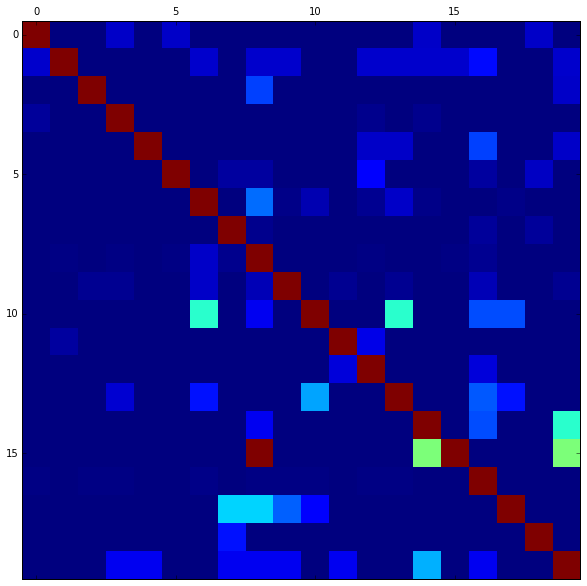

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
row_max = np.tile(cm.max(axis=1), (20, 1)).T
cm_normalized = np.true_divide(cm, row_max)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.matshow(cm_normalized)